### Packages What I imported

In [1]:
import personal_pkg as per
import pandas as pd
import numpy as np
from IPython.display import display , Markdown
import requests
from bs4 import BeautifulSoup
from scrapy.http import TextResponse
from datetime import datetime, timedelta
import nltk
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

### Adjusting the methodology of scoring
- 최댓값과 최솟값이 각각 4.0 -4.0 이 되도록 normalizing 한다.
- 그리고 LM_positive 은 2 값을 넣고, LM_negative에는 -2 값을 넣어준다.

In [2]:
stock_lex = pd.read_csv('stock_lex.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}

stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

display(pd.DataFrame(np.array(list(stock_lex_scaled.values()))).describe().loc[['min','max'],:])

,0
min,-4.0
max,4.0


In [3]:
# Loughran and McDonald
negative_ls = [i.strip() for i in per.convert_pdf_to_txt('LM_Negative.pdf').split('\n')]
negative_ls = [i for i in negative_ls if i and 'Negative' not in i]

positive_ls = [i.strip() for i in per.convert_pdf_to_txt('LM_Positive.pdf').split('\n')]
positive_ls = [i for i in positive_ls if i and 'Positive' not in i]

In [4]:
final_lex = {}
final_lex.update({word:2.0 for word in positive_ls})
final_lex.update({word:-2.0 for word in negative_ls})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

### Crawling the data

In [5]:
%%time

url_ls = []
date_ls = []
content_ls = []
score_ls = []

for page in range(1,10+1):
    req = requests.get("https://www.businesstimes.com.sg/search/facebook?page={}".format(page))
    http = TextResponse(req.url , body=req.text, encoding='utf-8')
    url_ls.append(http.xpath('//*[@id="sph-search-results"]/div/div/h4/a/@href').extract())
    date_ls.append(http.xpath('//*[@id="sph-search-results"]/div/div/time/text()').extract())
    
real_date_ls = [j for i in date_ls for j in i]
real_url_ls = [j for i in url_ls for j in i]

for idx,url in enumerate(real_url_ls) : 
    if idx % 30 == 0 : print(url)
    req = requests.get(url)
    dom = BeautifulSoup(req.text, 'lxml')
    content = ','.join([i.text for i in dom.findAll('p')]).replace(',',' ')
    content_ls.append(content)
    score_ls.append(sia.polarity_scores(content)['compound'])
    
date_ls = [datetime.strptime(i, '%d %b %Y').date() + timedelta(days=1) for i in real_date_ls]
date_sentiment = dict(zip(date_ls,score_ls))
earliest_date = min(date_sentiment.keys())

https://www.businesstimes.com.sg/technology/facebook-teaches-new-yorkers-about-privacy-at-pop-up-kiosk
https://www.businesstimes.com.sg/technology/oculus-brendan-iribe-is-latest-founder-to-leave-facebook
https://www.businesstimes.com.sg/technology/facebook-accused-of-allowing-bias-against-women-in-job-ads
https://www.businesstimes.com.sg/technology/facebook-uncovers-political-influence-campaign-ahead-of-us-midterm-elections
CPU times: user 9.53 s, sys: 242 ms, total: 9.77 s
Wall time: 3min 52s


In [6]:
score_df = pd.DataFrame.from_dict(date_sentiment,orient='index')
score_df.rename(columns={0:'score'},inplace=True)
score_df.sort_index(inplace=True)
score_df['1day_before'] = score_df.shift(periods=1)['score'].tolist()
score_df['diff'] = score_df['score'] - score_df['1day_before']
score_df.fillna(method='bfill',inplace=True)

In [7]:
signal_ls = []

for idx,val in enumerate(score_df['diff'].tolist()) : 
    if val >=0.5 : 
        signal_ls.append('buy')
    elif val <= -0.5 : 
        signal_ls.append('sell')
        
    else : signal_ls.append('0')

score_df['signal'] = signal_ls

In [8]:
score_df.reset_index(inplace=True)
score_df.rename(columns={'index':'Date'},inplace=True)

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import FinanceDataReader as fdr

# 값 설정
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True


In [10]:
start = earliest_date
end = datetime.datetime.now()

# FaceBook
df = fdr.DataReader("FB", start, end)
df = df[['Close', 'Volume']]
df.reset_index(inplace=True)

In [11]:
from datetime import datetime

In [12]:
revised_date_ls = []

for idx,val in enumerate(df['Date'].tolist()) :
    day = str(df['Date'][idx].day) + ' ' + str(df['Date'][idx].month) + ' ' + str(df['Date'][idx].year)
    revised_date_ls.append(datetime.strptime(day, '%d %m %Y').date())
df['Date'] = revised_date_ls

In [13]:
trade_df = pd.merge(score_df,df,on='Date')
trade_df.head()

,Date,score,1day_before,diff,signal,Close,Volume
0,2018-07-27,0.9490,0.9490,0.0487,0,174.89,60070000.0
1,2018-07-31,0.9961,0.9964,-0.0003,0,172.58,40360000.0
2,2018-08-02,0.9989,0.9961,0.0028,0,176.37,32400000.0
3,2018-08-08,0.9993,0.9976,0.0017,0,185.18,22210000.0
4,2018-08-14,0.9927,0.9993,-0.0066,0,181.11,19100000.0


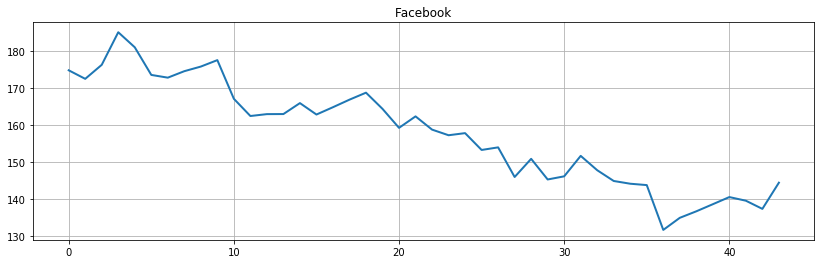

In [14]:
plt.title ('Facebook')
plt.plot(trade_df['Close'])
plt.show()

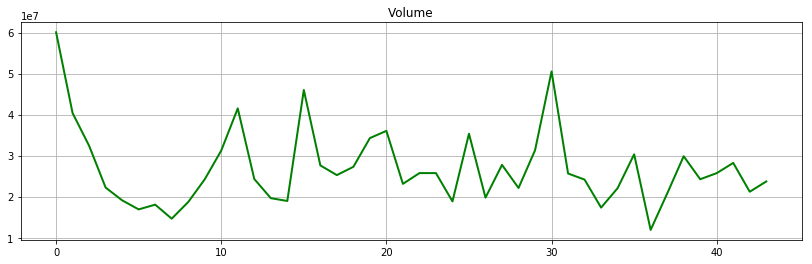

In [15]:
plt.title ('Volume')
plt.plot(trade_df['Volume'], color='g')
plt.show()

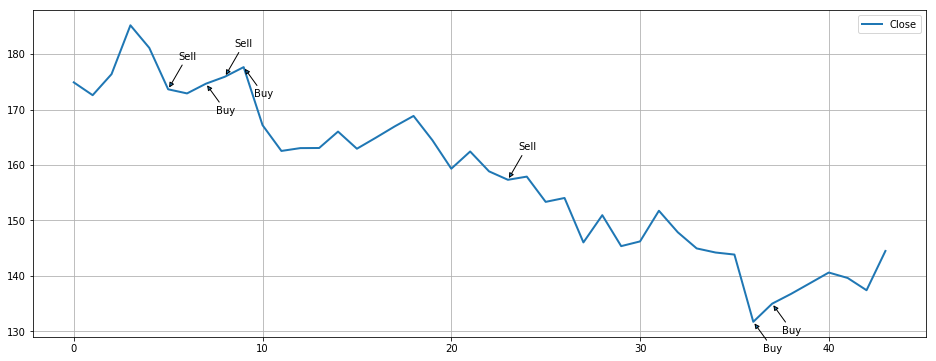

In [16]:
ax = trade_df[['Close']].plot(figsize=(16,6))
for key, val in trade_df['signal'].iteritems():
    if val == 0:
        continue

    if val == 'buy' :
        ax.annotate('Buy', xy=(key, trade_df['Close'][key]), xytext=(10,-30), 
                    textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    elif val == 'sell':
        ax.annotate('Sell', xy=(key, trade_df['Close'][key]), xytext=(10,30), 
                    textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
        

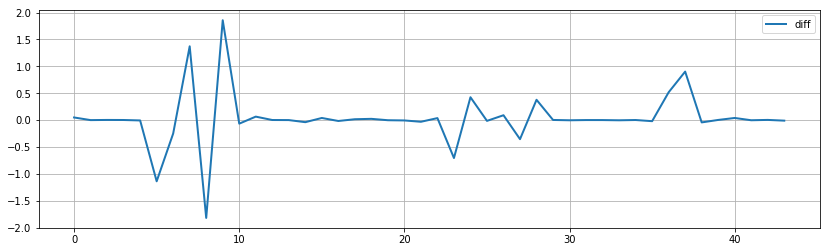

In [17]:
trade_df[['diff']].plot()